# **Default Payment Classification**

Name: Muhammad Fitri Amir bin Abdullah

Admin Number: P2222811

Class: DAAA/FT/2A/06
<hr>

## **Background Information:**
> A payment default usually happens after multiple payments on a loan or other debt are missed. The default happens when the lender decides to cut their losses and close the borrower's account because of missed payments.


In this task, I aim to predict customers of a bank who will have default payment using features such as:
- gender, 
- education, 
- credit limit<br> 
- payment history

Firstly, I will load the datasets and packages needed.

In [37]:
# Basic libs
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('../ST1511 AIML-CA1-datasets/credit_dataset.csv')

## **Exploratory Data Analysis**

In this section, I will find out more about the dataset and flag out flaws in the dataset.

In [38]:
#check data loaded

df.head()

,Customer ID,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,1,20000,female,univeresity,married,24,3913,3102,689,0,689,0,1
1,2,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000,1
2,3,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000,0
3,4,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200,0
4,5,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000,0


In [39]:
print(df.shape)
print(df.info())

df.isnull().sum()

df.nunique().sort_values()

(1600, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Customer ID                 1600 non-null   int64 
 1   Credit Limit                1600 non-null   int64 
 2   Gender                      1600 non-null   object
 3   Education                   1600 non-null   object
 4   Marriage Status             1600 non-null   object
 5   Age                         1600 non-null   int64 
 6   Bill_Amount1                1600 non-null   int64 
 7   Bill_Amount2                1600 non-null   int64 
 8   Bill_Amount3                1600 non-null   int64 
 9   Pay_Amount1                 1600 non-null   int64 
 10  Pay_Amount2                 1600 non-null   int64 
 11  Pay_Amount3                 1600 non-null   int64 
 12  Default payment next month  1600 non-null   int64 
dtypes: int64(10), object(3)
memory usage:

Gender                           2
Marriage Status                  2
Default payment next month       2
Education                        3
Age                             48
Credit Limit                    60
Pay_Amount3                    751
Pay_Amount2                    789
Pay_Amount1                    805
Bill_Amount3                  1373
Bill_Amount2                  1401
Bill_Amount1                  1440
Customer ID                   1600
dtype: int64

> As we can see, there are no null values in the datas given, and majority of the variables are integers, with gender,education and marriage status as objects. Furthermore, by using sort values, we can see that every feature has > 1 unique value, which means that I do not need to drop any other features.

## **Feature engineering**

In [40]:
df = df.drop(['Customer ID'], axis = 1)
df['Education'] = df['Education'].replace(['univeresity'], 'university')

df.head()

,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
0,20000,female,university,married,24,3913,3102,689,0,689,0,1
1,120000,female,university,single,26,2682,1725,2682,0,1000,1000,1
2,90000,female,university,single,34,29239,14027,13559,1518,1500,1000,0
3,50000,female,university,married,37,46990,48233,49291,2000,2019,1200,0
4,50000,male,university,married,57,8617,5670,35835,2000,36681,10000,0


Next, I will add 2 new columns, total_bill and total_pay to find out the total bill and paid by every customer as I feel that they may affect the classification later on. I also removed the bill and paid amounts columns as I feel that they can be summed up into the 2 new different columns.

In [41]:
df["Total_bill"] = ""
df["Total_paid"] = ""
df["Remaining_bill"] = ""

df['Total_bill'] = df['Bill_Amount1'] + df['Bill_Amount2'] + df['Bill_Amount3']
df['Total_paid'] = df['Pay_Amount1'] + df['Pay_Amount2'] + df['Pay_Amount3']
df['Remanining_bill'] = df["Total_bill"] - df["Total_paid"]


df = df.drop(columns = ['Bill_Amount1','Bill_Amount2','Bill_Amount3','Pay_Amount1','Pay_Amount2','Pay_Amount3'], axis = 1)
df = df.drop(['Remaining_bill'], axis = 1)
df.head()

,Credit Limit,Gender,Education,Marriage Status,Age,Default payment next month,Total_bill,Total_paid,Remanining_bill
0,20000,female,university,married,24,1,7704,689,7015
1,120000,female,university,single,26,1,7089,2000,5089
2,90000,female,university,single,34,0,56825,4018,52807
3,50000,female,university,married,37,0,144514,5219,139295
4,50000,male,university,married,57,0,50122,48681,1441


## **Data Preprocessing** 
> In this section, I will engineer the features. Firstly, I feel that Customer ID will not play a big part in classifying the data, therefore I will drop the column and I'll correct the typo made in the dataset (from univeresity to university) so that I wont make a mistake in my later codes 


C:\Users\Fitri\AppData\Local\Temp\ipykernel_29332\1042075593.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = corr_df.corr()


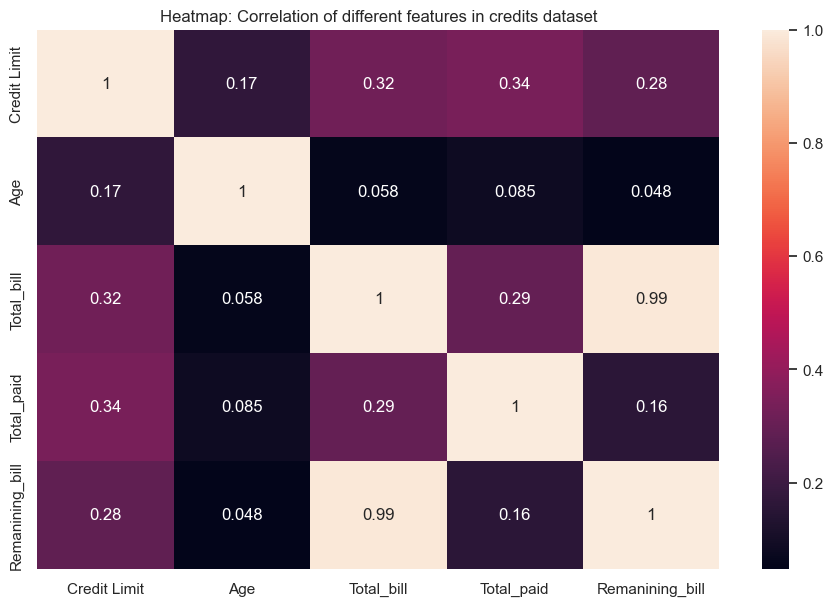

In [42]:

#Using seaborn to visualise the correlations in a heatmap
sns.set(rc={'figure.figsize':(11,7)})
corr_df = df.drop(['Default payment next month'], axis=1)

correlation = corr_df.corr()
sns.heatmap(correlation, cmap='rocket', annot=True)

#Using matplotlib to produce the plots
plt.title("Heatmap: Correlation of different features in credits dataset")
plt.show()

As we can see, `Gender`, `Education` and `Marriage Status` have categorical data. To use this data, I will have to encode it using 1 of 4 methods:

- pd.get_dummies()
- One Hot Encoder
- Label Encoder
- Ordinal Encoder

Firstly, `Gender` and `Marriage Status` are not ordinal, therefore I will have to use One Hot Encoder while `Education` is ordinal, which means I will use Ordinal/Label Encoder.

In [43]:
#Finding out the unique values in all the variables with categorical data.

a = df['Gender'].unique()
b = df['Education'].unique()
c = df['Marriage Status'].unique()

print(a,b,c)

#One hot encoder for gender as it is not ordinal

gender_encoder = OneHotEncoder(sparse=False)
gender_encoded = gender_encoder.fit_transform(df[['Gender']])
gender_df = pd.DataFrame(gender_encoded, columns=['Female', 'Male'])

# concatenate the new one-hot encoded gender dataframe to the original dataframe
df = pd.concat([df, gender_df], axis=1)

# drop the original 'Gender' column
df = df.drop(['Gender'], axis=1)

# rename the new columns to 'Male' and 'Female'
df = df.rename(columns={'Gender_Male': 'Male', 'Gender_Female': 'Female'})

df.head()

['female' 'male'] ['university' 'post-graduate' 'high school'] ['married' 'single']


c:\Users\Fitri\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Credit Limit,Education,Marriage Status,Age,Default payment next month,Total_bill,Total_paid,Remanining_bill,Female,Male
0,20000,university,married,24,1,7704,689,7015,1.0,0.0
1,120000,university,single,26,1,7089,2000,5089,1.0,0.0
2,90000,university,single,34,0,56825,4018,52807,1.0,0.0
3,50000,university,married,37,0,144514,5219,139295,1.0,0.0
4,50000,university,married,57,0,50122,48681,1441,0.0,1.0


In [44]:
#Marriage Status

# create encoder
encoder = OneHotEncoder()
encoded_array = encoder.fit_transform(df[['Marriage Status']]).toarray()

# create new dataframe with encoded values and column names
encoded_df = pd.DataFrame(encoded_array, columns=['Married', 'Single'])

# concatenate original dataframe with encoded dataframe
df = pd.concat([df, encoded_df], axis=1)

# drop original categorical column
df.drop('Marriage Status', axis=1, inplace=True)

# print resulting dataframe
print(df)

      Credit Limit      Education  Age  Default payment next month  \
0            20000     university   24                           1   
1           120000     university   26                           1   
2            90000     university   34                           0   
3            50000     university   37                           0   
4            50000     university   57                           0   
...            ...            ...  ...                         ...   
1595        480000     university   35                           0   
1596        150000     university   37                           0   
1597        110000  post-graduate   29                           0   
1598        240000  post-graduate   30                           0   
1599         50000  post-graduate   33                           1   

      Total_bill  Total_paid  Remanining_bill  Female  Male  Married  Single  
0           7704         689             7015     1.0   0.0      1.0     0.0  
1

In [45]:
#Lastly, ordinal encoder for education as it is ordinal

from sklearn.preprocessing import OrdinalEncoder

# create an instance of the OrdinalEncoder class
encoder = OrdinalEncoder(categories=[['high school', 'university', 'post-graduate']])

# fit and transform the 'Education' column
df['Education'] = encoder.fit_transform(df[['Education']])

df.head()

,Credit Limit,Education,Age,Default payment next month,Total_bill,Total_paid,Remanining_bill,Female,Male,Married,Single
0,20000,1.0,24,1,7704,689,7015,1.0,0.0,1.0,0.0
1,120000,1.0,26,1,7089,2000,5089,1.0,0.0,0.0,1.0
2,90000,1.0,34,0,56825,4018,52807,1.0,0.0,0.0,1.0
3,50000,1.0,37,0,144514,5219,139295,1.0,0.0,1.0,0.0
4,50000,1.0,57,0,50122,48681,1441,0.0,1.0,1.0,0.0


<font size = 4>
Take note that in this situation, 0 is high school, 1 is university and 2 is post graduate.<br>

Now that we have done our encoding, we can move on to our exploratory data analysis.

<font size = 4>
In this task, I feel that the False Positives are the most important to avoid as it may force customers to make default payment even though they may not need to. With that context set, I will list out a few ways of determining the results produced by the model.<br>

Since our feature space is not extremely large, we can afford to plot out a Pairplot to visualise the distribution of data points with relation to Target variable Default Payment

In [46]:
g = sns.pairplot(
    df,
    hue="Default payment next month",
    palette=["g", "r"],
    plot_kws=dict(alpha=0.9),
)
g.fig.suptitle("Pair plots between all variables of credits dataset", y=1.001, fontsize=18)
plt.show()

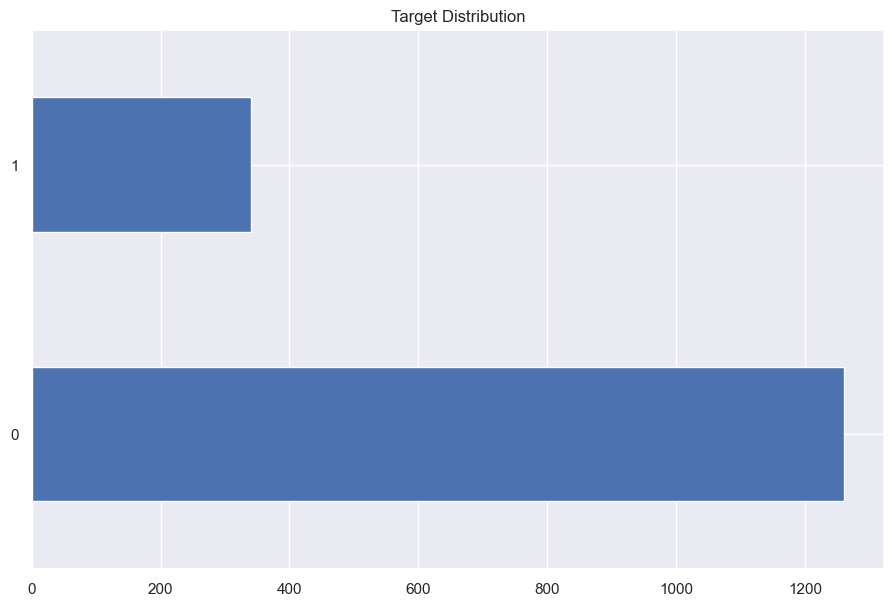

In [ ]:
ax = (
    df["Default payment next month"].value_counts().plot(kind="barh", title="Target Distribution")
)

In [ ]:
main_df = df.drop(['Default payment next month'], axis = 1)
target_df = df['Default payment next month']

trainX, testX, trainY, testY = train_test_split(main_df, target_df, test_size=0.2, random_state=42, stratify= target_df) # stratify so that percentage of samples are presered

# reset index for x_train and x_test
trainX = trainX.reset_index(drop=True)
testX = testX.reset_index(drop=True)

# reset index for y_train and y_test
trainY = trainY.reset_index(drop=True)
testY = testY.reset_index(drop=True)


#Show the percentages of trained/tested data that are 0s
print(f"Percentage of label '0' in Training data: {(len(trainY[trainY == 0]) / len(trainY)) * 100}%")
print(f"Percentage of label '0' in Test data: {(len(testY[testY == 0]) / len(testY)) * 100}%")

Percentage of label '0' in Training data: 78.75%
Percentage of label '0' in Test data: 78.75%


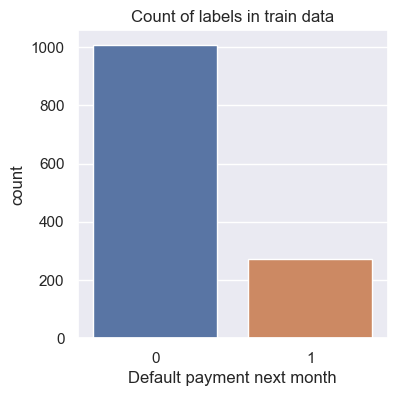

In [ ]:
#countplot to compare the count of both machine status in the dataset
sns.set(rc={'figure.figsize':(4,4)})
ax = sns.countplot(x= trainY)
plt.title('Count of labels in train data')
plt.show()

<font size = 4>
As we can see, the data is unbalanced. There are a lot more customers who do not need to pay default payments than those who need to pay. Due to this major imbalance, we will need to  find out a way in order to generate synthetic samples for the minority class, in this case customers required to pay default payment. <br><br>
To do that, we will use either Adaptive Synthetic Sampling Approach(ADASYN) or Synthetic Minority Oversampling Technique (SMOTE). In this task, I would prefer ADASYN as SMOTE adds too much noisy data points ie useless data, and also generates instances that are in the same direction, which complicates the decision surface made by a few classifier algorithms. Another way going about this problem is random oversampling. I feel that ADASYN is better than random oversampling as random oversampling duplicates existing minority class samples to balance the dataset. On the other hand, ADASYN generates new synthetic samples that are closer to the decision boundary, thereby addressing the issue of over-fitting.



SMOTE:<br>

![Alt text](SMOTE%20Example.png)

ADASYN:<br>

![Alt text](ADASYN%20Example.png)

<font size = 4>

To continue more about ADASYN, the way it works is that for each of the minority observations it first finds the impurity (the amount of majority data points) of the neighborhood, by taking the ratio of majority observations in the neighborhood and k (the minority points). This is an oversampling method, which means that the amount of minority datapoints will increase in order to match the amount of majority data points.

In [ ]:
counter = Counter(trainY)

print('Before', counter)

'''
By setting the random_state parameter to a fixed value,the algorithm generates the same synthetic samples 
each time it is run, which can make the results more reproducible
'''
ada = ADASYN(random_state = 42)
trainX_ada, trainY_ada = ada.fit_resample(trainX, trainY)

counter = Counter(trainY_ada)
print('After', counter)

Before Counter({0: 1008, 1: 272})


ValueError: could not convert string to float: 'university'

<hr>

## References:

https://gocardless.com/guides/posts/payment-defaults/ <br>
https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/<br>
https://medium.com/mlearning-ai/what-the-heck-is-random-state-24a7a8389f3d#<br>
https://www.kaggle.com/code/residentmario/oversampling-with-smote-and-adasyn